## 1. Preprocesamiento de datos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Link del dataset: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?resource=download

In [2]:
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

%matplotlib inline

In [3]:
%cd '/content/drive/MyDrive/Proyecto Desarrollo en Aplicaciones con Visión Artificial/COVID-19_Dataset'

path_train = './Train'
path_test = './Test'
train_image_files = glob(path_train + '/*/*.png')
test_image_files = glob(path_test + '/*/*.png')

/content/drive/.shortcut-targets-by-id/14LYEI5Mo5p_F1fHhFIjh04RTmjbpVPL9/Proyecto Desarrollo en Aplicaciones con Visión Artificial/COVID-19_Dataset


In [4]:
folders = glob(path_train + '/*')
print(folders)

['./Train/0', './Train/1']


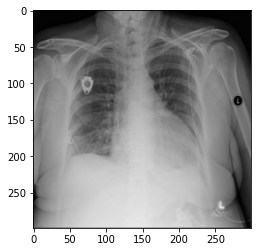

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

plt.imshow(image.load_img(np.random.choice(train_image_files)))

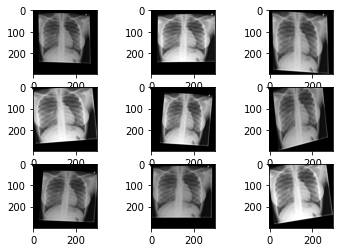

In [6]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('./Train/0/Normal-1.png')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(
    #rescale = 1./255,
    rotation_range = 10,
    width_shift_range = (-10,10),
    height_shift_range = (-10,10),
    brightness_range = (0.8, 1.2),
    shear_range = 5,
    zoom_range = (0.8,1.2),
    validation_split = 0.2
)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [7]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

train_validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    #rotation_range = 10,
    #width_shift_range = (-10,10),
    #height_shift_range = (-10,10),
    #brightness_range = (0.8, 1.2),
    #shear_range = 5,
    #zoom_range = (0.8,1.2),
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = train_validation_datagen.flow_from_directory(
    path_train,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    subset = 'training',
    color_mode = 'grayscale')

validation_generator = train_validation_datagen.flow_from_directory(
    path_train,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    subset = 'validation',
    color_mode = 'grayscale')

test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'grayscale')

Found 8837 images belonging to 2 classes.
Found 2209 images belonging to 2 classes.
Found 2762 images belonging to 2 classes.


## 2. Creación del modelo COVID19-Net

In [8]:
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout

from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

In [9]:
def COVID19_Net(input_shape, num_classes, l2_regularization=0.01):
  
  K.clear_session()

  regularization = l2(l2_regularization)

  inputs = Input(shape=(input_shape))

  convolutional_1 = Conv2D(filters=128, kernel_size=(3,3),
                           activation='relu', kernel_initializer='he_normal')(inputs)
  max_pooling_1 = MaxPooling2D(pool_size=(2, 2))(convolutional_1)
  max_pooling_1 = BatchNormalization()(max_pooling_1)

  convolutional_2 = Conv2D(filters=256, kernel_size=(4, 4),
                           activation="relu", kernel_initializer="he_normal")(max_pooling_1)
  max_pooling_2 = MaxPooling2D(pool_size=(2, 2))(convolutional_2)
  max_pooling_2 = BatchNormalization()(max_pooling_2)

  convolutional_3 = Conv2D(filters=256, kernel_size=(4, 4),
                           activation="relu", padding="same", kernel_initializer="he_normal")(max_pooling_2)
  max_pooling_3 = MaxPooling2D(pool_size=(2, 2))(convolutional_3)
  max_pooling_3 = BatchNormalization()(max_pooling_3)

  convolutional_4 = Conv2D(filters=256, kernel_size=(4, 4),
                           activation="relu", padding="same", kernel_initializer="he_normal")(max_pooling_3)
  max_pooling_4 = MaxPooling2D(pool_size=(2, 2))(convolutional_4)
  max_pooling_4 = BatchNormalization()(max_pooling_4)

  convolutional_5 = Conv2D(filters=256, kernel_size=(4, 4),
                           activation="relu", padding="same", kernel_initializer="he_normal")(max_pooling_4)
  max_pooling_5 = MaxPooling2D(pool_size=(2, 2))(convolutional_5)
  max_pooling_5 = BatchNormalization()(max_pooling_5)

  flatten = Flatten()(max_pooling_5)
  dense_1 = Dense(units=2048, activation="relu")(flatten)
  dense_1 = Dropout(0.4)(dense_1)
  dense_2 = Dense(units=1024, activation="relu")(dense_1)
  dense_2 = Dropout(0.4)(dense_1)
  
  outputs = Dense(units=1, activation="sigmoid")(dense_2)

  model = Model(inputs=inputs, outputs=outputs)

  return model

In [10]:
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate,
                               decay_steps=100000,
                               decay_rate=0.96,
                               staircase=True)

checkpoint = ModelCheckpoint("model-epoch:{epoch:02d}-loss:{loss:.3f}-val_acc:{val_acc:.3f}-weights", monitor="val_acc", mode="max")

early_stopping = EarlyStopping(monitor="val_acc", patience=10, mode="max")

callbacks = [checkpoint, early_stopping]

In [11]:
model = COVID19_Net(input_shape=(150,150,1), num_classes=2)

model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss="binary_crossentropy",
              metrics=["acc"])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 256)       524544    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 256)      0     

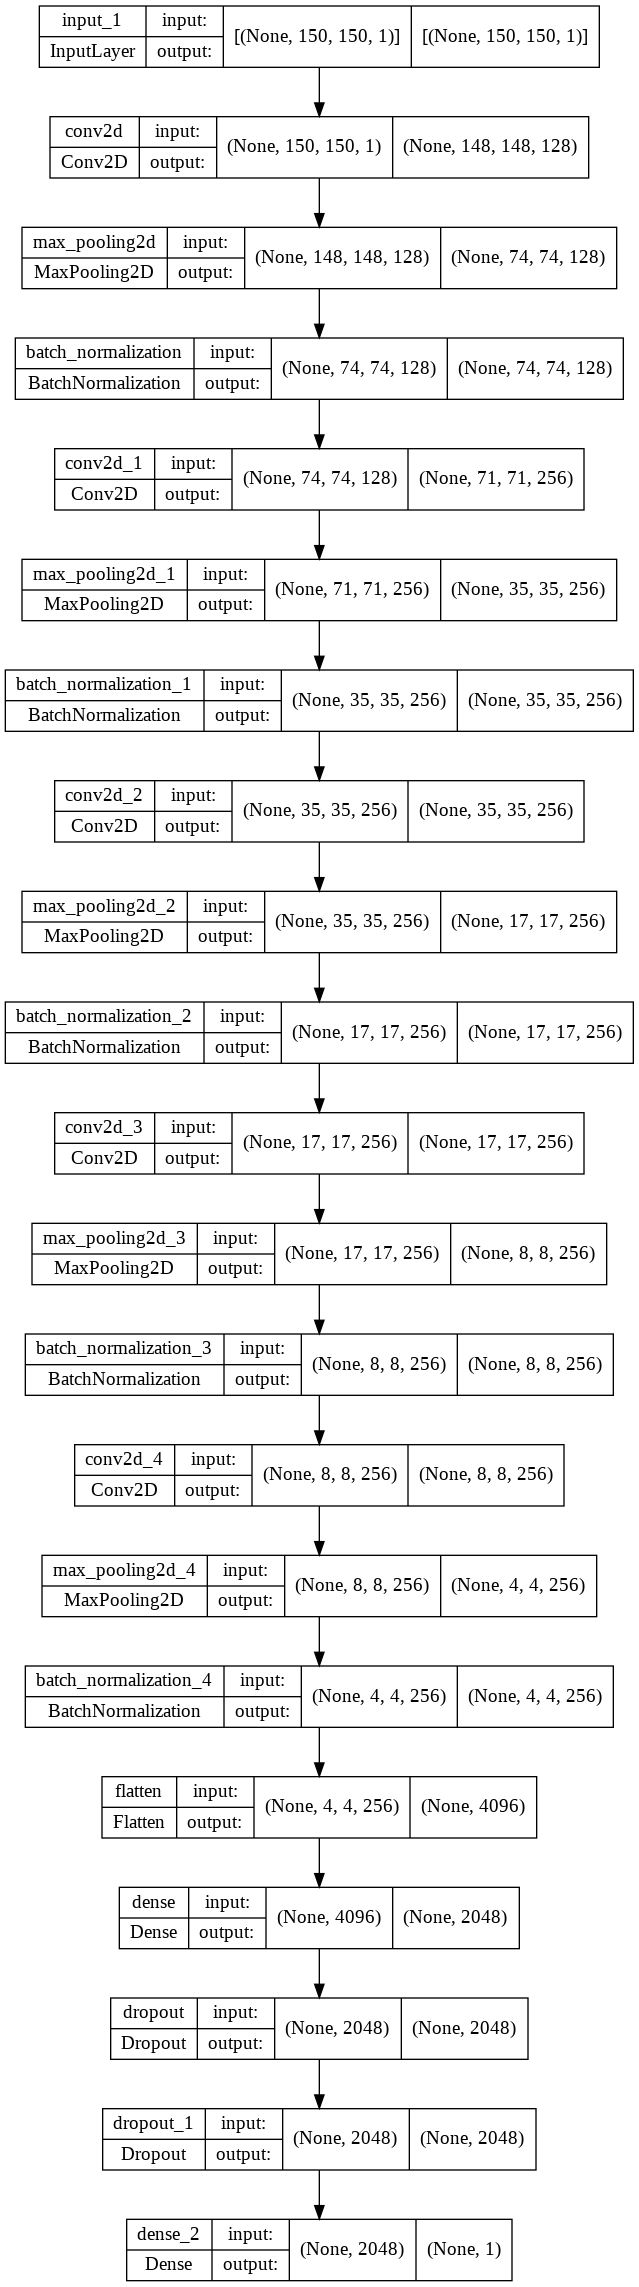

In [13]:
plot_model(model, to_file="model6.png", show_shapes=True)

## 3. Entrenamiento de la red neuronal

In [15]:
epochs = 40

log = model.fit(train_generator,
                batch_size=256,
                epochs=epochs,
                verbose=1,
                callbacks=callbacks,
                validation_data=validation_generator)

Epoch 1/40
277/277 [==============================] - 2155s 8s/step - loss: 0.2936 - acc: 0.8920 - val_loss: 0.8372 - val_acc: 0.5419
Epoch 2/40
277/277 [==============================] - 63s 227ms/step - loss: 0.1485 - acc: 0.9446 - val_loss: 0.1750 - val_acc: 0.9325
Epoch 3/40
277/277 [==============================] - 65s 234ms/step - loss: 0.0933 - acc: 0.9667 - val_loss: 0.1219 - val_acc: 0.9597
Epoch 4/40
277/277 [==============================] - 66s 239ms/step - loss: 0.0658 - acc: 0.9751 - val_loss: 0.1614 - val_acc: 0.9507
Epoch 5/40
277/277 [==============================] - 65s 235ms/step - loss: 0.0592 - acc: 0.9790 - val_loss: 0.1609 - val_acc: 0.9543
Epoch 6/40
277/277 [==============================] - 65s 235ms/step - loss: 0.0318 - acc: 0.9881 - val_loss: 0.1659 - val_acc: 0.9561
Epoch 7/40
277/277 [==============================] - 66s 237ms/step - loss: 0.0291 - acc: 0.9896 - val_loss: 0.1304 - val_acc: 0.9638
Epoch 8/40
277/277 [==============================] - 66

## 4. Visualización de resultados

In [16]:
def show_results(log):
  val_loss = log.history['val_loss']
  val_acc = log.history['val_acc']
      
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes
  ax1.plot(log.history['loss'], label='train')
  ax1.plot(val_loss, label='test')
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  ax2.plot(log.history['acc'], label='train')
  ax2.plot(val_acc, label='test')
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  for ax in axes: ax.legend()

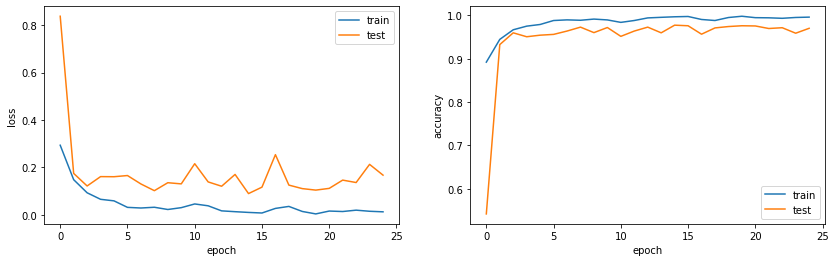

In [17]:
show_results(log)

### 4.1. Métricas de la mejor red obtenida

In [18]:
def round_values(values):
  return K.round(values)

def binary_accuracy(y_true, y_pred):
  return K.mean(K.equal(y_true, round_values(y_pred))).numpy()

In [19]:
from tensorflow.keras.models import load_model

model = load_model("model-epoch:20-loss:0.004-val_acc:0.976-weights")

In [20]:
val_loss, val_acc = model.evaluate(test_generator)

print("Validation: Loss -> {:.4f} | Accuracy {:.4f}".format(val_loss, val_acc))

87/87 [==============================] - 783s 9s/step - loss: 0.1082 - acc: 0.9786
Validation: Loss -> 0.1082 | Accuracy 0.9786


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()

In [23]:
N_valid = 8837
true_values_train = np.zeros(N_valid)
predicted_values_train = np.zeros(N_valid)

i = 0
for batch_x_train, batch_y_train in train_generator:
    batch_train_predictions = model(batch_x_train)
  
    sz = len(batch_y_train) 
    true_values_train[i:i+sz] = batch_y_train[:sz]
    predicted_values_train[i:i+sz] = batch_train_predictions.numpy().reshape(-1)
    
    i += sz
    #if i%10==0:
        #print(i)

    if i>=N_valid:
        print('breaking now')
        break

N_valid = 2209
true_values_validation = np.zeros(N_valid)
predicted_values_validation = np.zeros(N_valid)

i = 0
for batch_x_validation, batch_y_validation in validation_generator:
    batch_validation_predictions = model(batch_x_validation)
  
    sz = len(batch_y_validation) 
    true_values_validation[i:i+sz] = batch_y_validation[:sz]
    predicted_values_validation[i:i+sz] = batch_validation_predictions.numpy().reshape(-1)
    
    i += sz
    #if i%10==0:
        #print(i)

    if i>=N_valid:
        print('breaking now')
        break

N_valid = len(test_image_files)
true_values_test = np.zeros(N_valid)
predicted_values_test = np.zeros(N_valid)

i = 0
for batch_x_test, batch_y_test in test_generator:
    batch_test_predictions = model(batch_x_test)
  
    sz = len(batch_y_test) 
    true_values_test[i:i+sz] = batch_y_test[:sz]
    predicted_values_test[i:i+sz] = batch_test_predictions.numpy().reshape(-1)
    
    i += sz
    #if i%10==0:
        #print(i)

    if i>=N_valid:
        print('breaking now')
        break

breaking now
breaking now
breaking now



-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6560
         1.0       1.00      1.00      1.00      2277

    accuracy                           1.00      8837
   macro avg       1.00      1.00      1.00      8837
weighted avg       1.00      1.00      1.00      8837

--------------------------------------------------------------------------
Recall on Train Data:  0.9987
Specificity on Train Data:  0.9997
Accuracy on Train Data:  0.9994
Precision on Train Data:  0.9991
F1 Score on Train Data:  0.9989
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1640
         1.0       0.97      0.94      0.95       569

    accuracy                

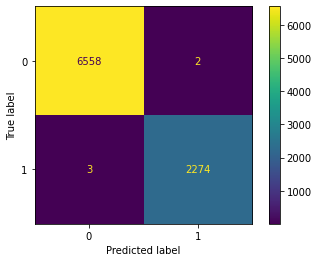

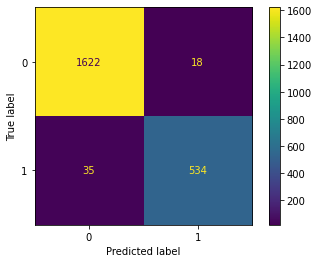

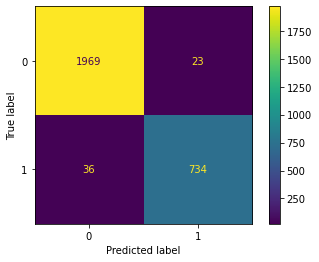

In [24]:
evaluation_parametrics("Convolution Neural Network", true_values_train, np.rint(predicted_values_train), true_values_validation, np.rint(predicted_values_validation), true_values_test, np.rint(predicted_values_test))